This notebook is fine-tuning the Segment-Anything-Model (SAM) for surface water segmentation for SAR remote sensing images (Kompsat-5, ALOS-2, Sentinel-1). The program is modified from Armin Moghimi et al. by Nguyen Hong Quang et al. in Gihong Kim's lab.

We would like to express our thanks to Armin Moghimi et al. for providing the code freely on GitHub.

Other users are advised to refer to https://github.com/ArminMoghimi/Fine-tune-the-Segment-Anything-Model-SAM-  for accessing the original code.

For the Korean-user beneficiaries, we translated all the code explanations into Korean.

Thank you very much!

In [1]:
PyTorch 라이브러리를 가져오고 GPU 상태를 확인합니다.
import torch
print (torch.cuda.device_count())
print (torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4090


In [2]:
#라이브러리 가져오기
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from numpy import zeros
from numpy.random import randint
import torch
import os
import cv2
from statistics import mean
from torch.nn.functional import threshold, normalize
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

segment_anything 및 해당 종속성을 가져옵니다.

In [3]:
#! pip install torch torchvision
#! pip install opencv-python pycocotools matplotlib onnxruntime onnx
#! pip install git+https://github.com/facebookresearch/segment-anything.git
#!curl -L https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -o sam_vit_b_01ec64.pth
#!curl -L https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth -o sam_vit_l_0b3195.pth
#!curl -L https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -o sam_vit_h_4b8939.pth

교육 데이터 가져오기



In [5]:
image_path = "D:/DATA/SAM_Fine_Tune/ForSAM/Images/train/AL2_train"
total_images = len(os.listdir(image_path))
all_image_paths = sorted(glob(image_path + "/*.JPG"))
print(f"Total Number of Images : {total_images}")
lable_path = "D:/DATA/SAM_Fine_Tune/ForSAM/MASKS/train/AL2_train"
total_lables = len(os.listdir(lable_path))
all_lable_paths = sorted(glob(lable_path + "/*.PNG"))
print(f"Total Number of Images : {total_lables}")
train_image_paths = all_image_paths[0:total_images]
train_lable_paths = all_lable_paths[0:total_lables]

Total Number of Images : 442
Total Number of Images : 442


가져오기 검증 데이터

In [6]:
image_path = "D:/DATA/SAM_Fine_Tune/ForSAM/Images/val_/AL2_val_"
Val_total_images = len(os.listdir(image_path))
all_image_paths = sorted(glob(image_path + "/*.JPG"))
print(f"Total Number of Images : {Val_total_images}")
lable_path = "D:/DATA/SAM_Fine_Tune/ForSAM/MASKS/val_/AL2_val_"
Val_total_lables = len(os.listdir(lable_path))
all_lable_paths = sorted(glob(lable_path + "/*.PNG"))
print(f"Total Number of Images : {Val_total_lables}")
Val1_image_paths = all_image_paths[0:Val_total_images]
Val1_lable_paths = all_lable_paths[0:Val_total_lables]

Total Number of Images : 111
Total Number of Images : 111


훈련 및 검증을 위한 ground_truth_masks 읽기

In [7]:
# 입력 이미지의 원래 크기를 사용하려면 이 줄을 실행하지 마세요.
desired_size=(512, 512)
#desired_size=None

In [8]:
ground_truth_masks = {}
for k in range(0, len(train_image_paths)):
    gt_grayscale = cv2.imread(train_lable_paths[k], cv2.IMREAD_GRAYSCALE)
    if desired_size is not None:
        gt_grayscale = cv2.resize(gt_grayscale, desired_size, interpolation=cv2.INTER_LINEAR)

    ground_truth_masks[k] = (gt_grayscale > 0)

In [9]:
ground_truth_masksv = {}
for s in range(0, len(Val1_lable_paths)):
    gt_grayscale = cv2.imread(Val1_lable_paths[s], cv2.IMREAD_GRAYSCALE)
    if desired_size is not None:
        gt_grayscale = cv2.resize(gt_grayscale, desired_size, interpolation=cv2.INTER_LINEAR)

    ground_truth_masksv[s] = (gt_grayscale > 0)

SAM 모델 가져오기

In [10]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [11]:
model_type = 'vit_l'
checkpoint = 'sam_vit_h_4b8939.pth'
device = 'cuda:0'

In [12]:
model_type = "vit_h"
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = 'cuda:0'

In [13]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model.to(device)
sam_model.train();

#1단계: 학습을 위한 이미지 사전 처리

> 들여쓰기 블록




In [14]:
from collections import defaultdict
from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in range(len(train_image_paths)):  # 루프 반복을 수정하세요
    image = cv2.imread(train_image_paths[k])
    if desired_size is not None:
        image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    input_image = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam_model.preprocess(transformed_image)
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])

    transformed_data[k]['image'] = input_image
    transformed_data[k]['input_size'] = input_size
    transformed_data[k]['original_image_size'] = original_image_size


# 최적화 프로그램 및 손실을 설정합니다.


In [15]:
lr = 1e-5
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)
loss_fn   = torch.nn.BCEWithLogitsLoss()
keys = list(ground_truth_masks.keys())
keys1 = list(ground_truth_masksv.keys())
# GPU를 사용할 수 있는지 확인하세요
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 배치 크기 정의
batch_size = 16
num_epochs = 250

# 훈련 데이터를 통한 SAM 미세 조정

In [16]:
def train_on_batch(keys, batch_start, batch_end):
    batch_losses = []
    batch_accuracies = []

    for k in keys[batch_start:batch_end]:
        input_image = transformed_data[k]['image'].to(device)
        input_size = transformed_data[k]['input_size']
        original_image_size = transformed_data[k]['original_image_size']

        # 인코더를 최적화하고 싶지 않으므로 여기에는 졸업이 없습니다.
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)

            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
            )

        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
        binary_mask = (threshold(torch.sigmoid(upscaled_masks), 0.5, 0))
        gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
        gt_mask_resized = gt_mask_resized > 0.5
        gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

        loss = loss_fn(binary_mask, gt_binary_mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

        # 훈련 데이터의 정확도 계산
        train_accuracy = calculate_accuracy(binary_mask, gt_binary_mask)
        batch_accuracies.append(train_accuracy)

    return batch_losses, batch_accuracies

def calculate_accuracy(predictions, targets):
    binary_predictions = (predictions > 0.5).float()
    accuracy = (binary_predictions == targets).float().mean()
    return accuracy.item()

losses = []
val_losses = []
accuracies = []
best_val_loss = float('inf')  # 최상의 검증 손실을 양의 무한대로 초기화합니다.
val_acc = []

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []

    # 일괄 처리를 사용한 훈련 루프
    for batch_start in range(0, len(keys), batch_size):
        batch_end = min(batch_start + batch_size, len(keys))

        batch_losses, batch_accuracies = train_on_batch(keys, batch_start, batch_end)

        # 현재 배치에 대한 정확도 계산
        batch_accuracy = mean(batch_accuracies)
        epoch_accuracies.extend(batch_accuracies)

        # 현재 배치에 대한 평균 교육 손실 계산
        batch_loss = mean(batch_losses)
        epoch_losses.append(batch_loss)

        print(f'Batch: [{batch_start+1}-{batch_end}]')
        print(f'Batch Loss: {batch_loss}')
        print(f'Batch Accuracy: {batch_accuracy}')

    # 현재 에포크에 대한 평균 훈련 손실 계산
    mean_train_loss = mean(epoch_losses)
    mean_train_accuracy = mean(epoch_accuracies)
    losses.append(mean_train_loss)
    accuracies.append(mean_train_accuracy)

    print(f'EPOCH: {epoch}')
    print(f'Mean training loss: {mean_train_loss}')
    print(f'Mean training accuracy: {mean_train_accuracy}')

    predictor_tuned = SamPredictor(sam_model)

    # 검증 루프
    val_loss = 0.0
    val_accuracy = 0.0
    num_val_examples = 0
    with torch.no_grad():
        for s in keys1[:len(Val1_image_paths)]:  # validation_keys를 검증 데이터 키로 바꾸세요.
            image = cv2.imread(Val1_image_paths[s])
            if desired_size is not None:
               image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # 검증 데이터에 대한 전달
            predictor_tuned.set_image(image)

            masks_tuned, _, _ = predictor_tuned.predict(
                point_coords=None,
                box=None,
                multimask_output=False,
            )

            gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masksv[s], (1, 1, ground_truth_masksv[s].shape[0], ground_truth_masksv[s].shape[1]))).to(device)
            gt_mask_resized = gt_mask_resized > 0.5
            gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
            masks_tuned1 = torch.as_tensor(masks_tuned > 0, dtype=torch.float32)
            new_tensor = masks_tuned1.unsqueeze(0).to(device)

            # 검증 손실 계산
            val_loss += loss_fn(new_tensor, gt_binary_mask).item()

            # 검증 데이터의 정확도 계산
            val_accuracy += calculate_accuracy(new_tensor, gt_binary_mask)
            num_val_examples += 1

    # 현재 에포크에 대한 평균 검증 손실 계산
    val_loss /= num_val_examples
    val_losses.append(val_loss)
    print(f'Mean validation loss: {val_loss}')

    # 현재 에포크에 대한 평균 검증 정확도 계산
    mean_val_accuracy = val_accuracy / num_val_examples
    val_acc.append(mean_val_accuracy)
    print(f'Mean validation accuracy: {mean_val_accuracy}')

    # 검증 정확도가 향상되면 모델 체크포인트를 저장합니다.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        models_path = "D:/DATA/SAM_Fine_Tune/Water-Bodies-Dataset/Model_Path"
        torch.save(sam_model.state_dict(), os.path.join(models_path, 'SAM_AL2weights_ViTB_300epoch.pth'))

    # 각 에포크마다 GPU 캐시를 지웁니다.
    torch.cuda.empty_cache()


Batch: [1-16]
Batch Loss: 0.7144747041165829
Batch Accuracy: 0.843513011932373
Batch: [17-32]
Batch Loss: 0.6933058314025402
Batch Accuracy: 0.9259159564971924
Batch: [33-48]
Batch Loss: 0.6932508796453476
Batch Accuracy: 0.9213299751281738
Batch: [49-64]
Batch Loss: 0.6931453458964825
Batch Accuracy: 0.9244413375854492
Batch: [65-80]
Batch Loss: 0.6928537115454674
Batch Accuracy: 0.9235632419586182
Batch: [81-96]
Batch Loss: 0.6909490823745728
Batch Accuracy: 0.9032366275787354
Batch: [97-112]
Batch Loss: 0.6899833530187607
Batch Accuracy: 0.9250798225402832
Batch: [113-128]
Batch Loss: 0.6973537504673004
Batch Accuracy: 0.9069254398345947
Batch: [129-144]
Batch Loss: 0.689670093357563
Batch Accuracy: 0.9401557445526123
Batch: [145-160]
Batch Loss: 0.6833001151680946
Batch Accuracy: 0.9562654495239258
Batch: [161-176]
Batch Loss: 0.6774459332227707
Batch Accuracy: 0.9606914520263672
Batch: [177-192]
Batch Loss: 0.6850391663610935
Batch Accuracy: 0.9577114582061768
Batch: [193-208]
Bat

#3단계: 미세 조정된 SAM 모델 테스트

In [17]:
image_path = "D:/DATA/SAM_Fine_Tune/ForSAM/SAM_Test/Images"
test_total_images = len(os.listdir(image_path))
all_image_paths = sorted(glob(image_path + "/*.JPG"))
print(f"Total Number of Test Images : {test_total_images}")
lable_path = "D:/DATA/SAM_Fine_Tune/ForSAM/SAM_Test/Masks"
test_total_lables = len(os.listdir(lable_path))
all_lable_paths = sorted(glob(lable_path + "/*.PNG"))
print(f"Total Number of Test Images : {test_total_lables}")
Test_image_paths = all_image_paths[0:test_total_images]
Test_lable_paths = all_lable_paths[0:test_total_lables]

Total Number of Test Images : 36
Total Number of Test Images : 36


테스트용 상자 *데이터*

지상_진실_테스트_마스크

In [18]:
ground_truth_test_masks = {}
for k in range(0, len(all_image_paths)):
  gt_grayscale = cv2.imread(Test_lable_paths[k])
  ground_truth_test = (gt_grayscale[:,:,2]>0).astype(np.float32)
  if desired_size is not None:
      ground_truth_test = cv2.resize(ground_truth_test, desired_size, interpolation=cv2.INTER_NEAREST)

  ground_truth_test_masks[k] = (ground_truth_test).astype(np.float32)

최상의 매개변수로 훈련된 모델을 로드합니다.

Fine_tuned 모델을 사용한 예측

In [19]:
masks_tuned_list = {}
images_tuned_list= {}
for k in range(0, len(all_image_paths)):
    # 이미지를 로드하고 색상 공간을 변환합니다.
    image = cv2.cvtColor(cv2.imread(Test_image_paths[k]), cv2.COLOR_BGR2RGB)
    if desired_size is not None:
       image = cv2.resize(image, desired_size, interpolation=cv2.INTER_LINEAR)

    predictor_tuned.set_image(image)

    # predictor_tuned 객체를 사용하여 예측 수행
    masks_tuned, _, _ = predictor_tuned.predict(
        point_coords=None,
        box=None,
        multimask_output=False,
    )

    # 예측에서 첫 번째 마스크를 얻으세요
    kk = masks_tuned[0, :, :]
    binary_mask = (kk > 0).astype(np.float32)
    # 최근접 이웃 보간을 사용하여 마스크 크기를 원하는 크기로 조정합니다.
    images_tuned_list[k]  = image
    masks_tuned_list[k]  = binary_mask

모든 테스트 데이터에 대한 플롯 결과

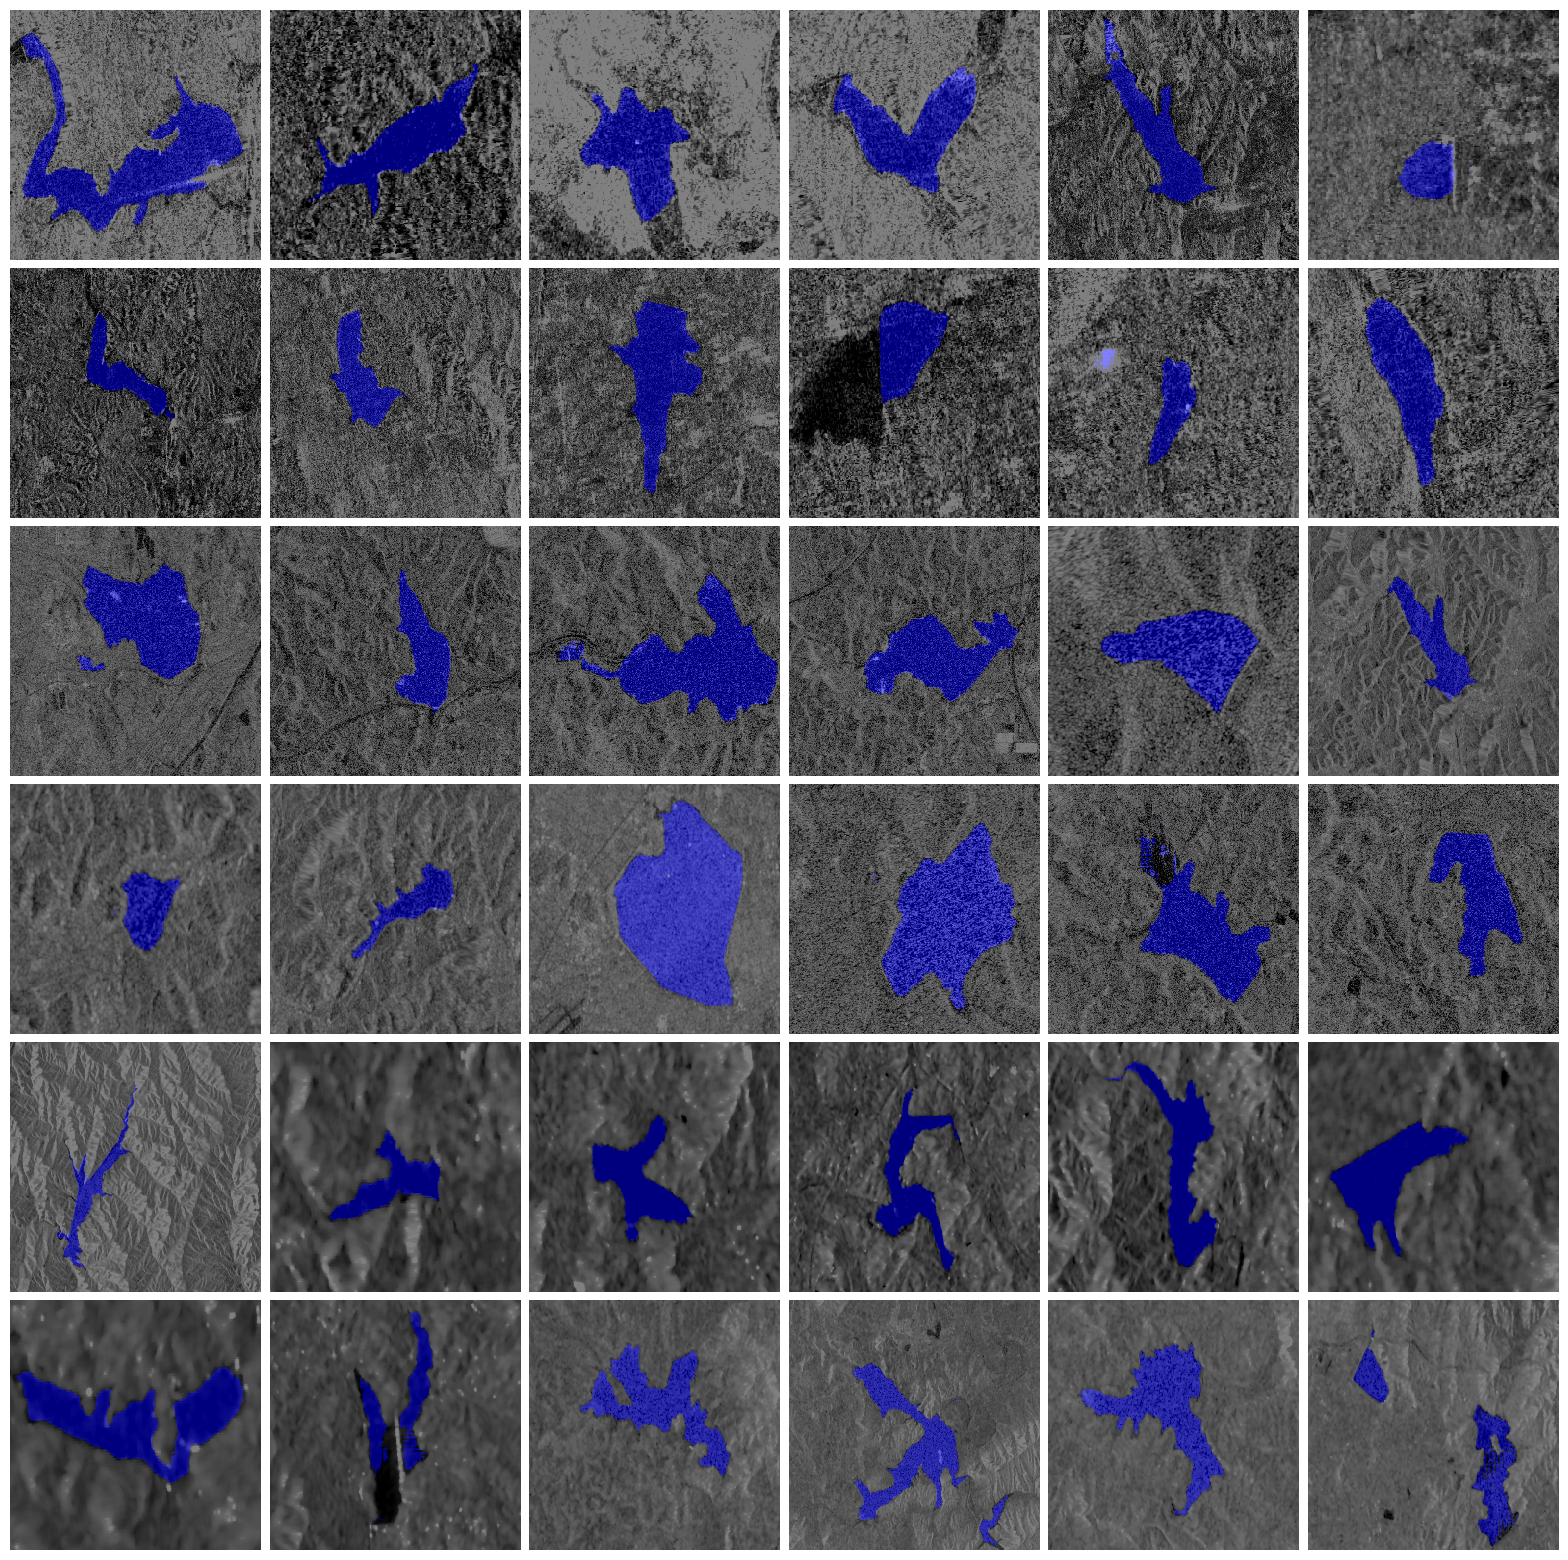

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# images_tuned_list와 masks_binary_list가 각각 RGB 이미지와 바이너리 마스크 목록이라고 가정합니다.

# 6x6 서브플롯 그리드를 만듭니다.
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

# 행과 열을 반복합니다.
for i in range(6):
    for j in range(6):
        # images_tuned_list 및 masks_binary_list에 대한 인덱스를 계산합니다.
        index = i * 6 + j

        # 인덱스가 데이터 범위 내에 있는지 확인하세요
        if index < len(images_tuned_list):
            # RGB 이미지 표시
            axs[i, j].imshow(images_tuned_list[index], interpolation='none')

            # 알파 채널이 있는 파란색 마스크 만들기
            blue_mask = np.zeros_like(masks_tuned_list[index])
            blue_mask[masks_tuned_list[index] == 1] = 1
            blue_mask_rgb = np.stack([np.zeros_like(blue_mask), np.zeros_like(blue_mask), blue_mask], axis=-1)
            # RGB 이미지에 파란색 마스크를 오버레이합니다.
            axs[i, j].imshow(blue_mask_rgb, alpha=0.50)


            axs[i, j].axis('off')

# 이미지 간 간격 줄이기
plt.subplots_adjust(wspace=0.03, hspace=0.03)

# 서브플롯 레이블이 잘리지 않도록 레이아웃을 조정하세요
#plt.tight_layout()
#output_path = '/content/output_figure1200mobilsam.png'
#plt.savefig(output_path, dpi=1200, bbox_inches='tight')
plt.show()

In [21]:
import torch
import numpy as np
from sklearn.metrics import auc, roc_curve

def binary_segmentation_metrics(predictions, targets):
    # 토치 텐서를 넘파이 배열로 변환

    predictions = predictions.squeeze()
    targets = targets
    # 예측을 이진 값(0 또는 1)으로 변환
    predictions_binary = (predictions > 0.5).astype(int)
    targets_binary = targets.astype(int)

    # 예측을 이진 값(0 또는 1)으로 변환
    predictions_binary = (predictions > 0.5).astype(int)

    # True Positives (TP): 예측과 타겟이 모두 양성입니다.
    TP = np.sum((predictions_binary == 1) & (targets == 1))

    # 거짓 양성(FP): 예측은 양성이지만 대상은 음성입니다.
    FP = np.sum((predictions_binary == 1) & (targets == 0))

    # 거짓 부정(FN): 예측은 부정이지만 대상은 양성입니다.
    FN = np.sum((predictions_binary == 0) & (targets == 1))

    # True Negatives (TN): 예측과 타겟이 모두 음수입니다.
    TN = np.sum((predictions_binary == 0) & (targets == 0))

    eps = 1e-5
    accuracy = (TP + TN + eps) / (TP + FP + FN + TN + eps)
    precision = (TP + eps) / (TP + FP + eps)
    recall = (TP + eps) / (TP + FN + eps)
    f_score = 2 * (precision * recall) / (precision + recall)
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    iou = (TP + eps) / (TP + FP + FN + eps)

    total = TP + FP + FN + TN
    p_o = (TP + TN) / total
    p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
    kappa = (p_o - p_e) / (1 - p_e)

    return accuracy, precision, recall, f_score, iou, kappa, FP, FN, TP, TN, dice

def calculate_average_metrics(predictions_list, targets_list):
    num_masks = len(predictions_list)

    total_metrics = {
        'accuracy': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f_score': 0.0,
        'iou': 0.0,
        'kappa': 0.0,
        'FP': 0,
        'FN': 0,
        'MAR': 0.0,
        'FAR': 0.0,
        'dice': 0.0
    }

    for i in range(num_masks):
        metrics = binary_segmentation_metrics(predictions_list[i], targets_list[i])

        for metric_name, value in zip(total_metrics.keys(), metrics):
            total_metrics[metric_name] += value

        total_metrics['MAR'] += metrics[8] / (metrics[8] + metrics[9])
        total_metrics['FAR'] += metrics[6] / (metrics[9] + metrics[6])

    avg_metrics = {k: v / num_masks for k, v in total_metrics.items()}

    return avg_metrics

# 사용 예

avg_metrics = calculate_average_metrics(masks_tuned_list, ground_truth_test_masks)

for metric_name, value in avg_metrics.items():
    print(f"Average {metric_name}: {value}")

Average accuracy: 0.9870811038552022
Average precision: 0.9608656573158625
Average recall: 0.9215223637342356
Average f_score: 0.9349831591159019
Average iou: 0.8868453622010908
Average kappa: nan
Average FP: 903.5277777777778
Average FN: 2483.0833333333335
Average MAR: 25729.68277830745
Average FAR: 233027.80947721459
Average dice: 0.9349831591001855


C:\Users\user\AppData\Local\Temp\ipykernel_22044\5620428.py:39: RuntimeWarning: overflow encountered in scalar multiply
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
C:\Users\user\AppData\Local\Temp\ipykernel_22044\5620428.py:39: RuntimeWarning: divide by zero encountered in scalar divide
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
C:\Users\user\AppData\Local\Temp\ipykernel_22044\5620428.py:40: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_o - p_e) / (1 - p_e)
C:\Users\user\AppData\Local\Temp\ipykernel_22044\5620428.py:39: RuntimeWarning: overflow encountered in scalar add
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)


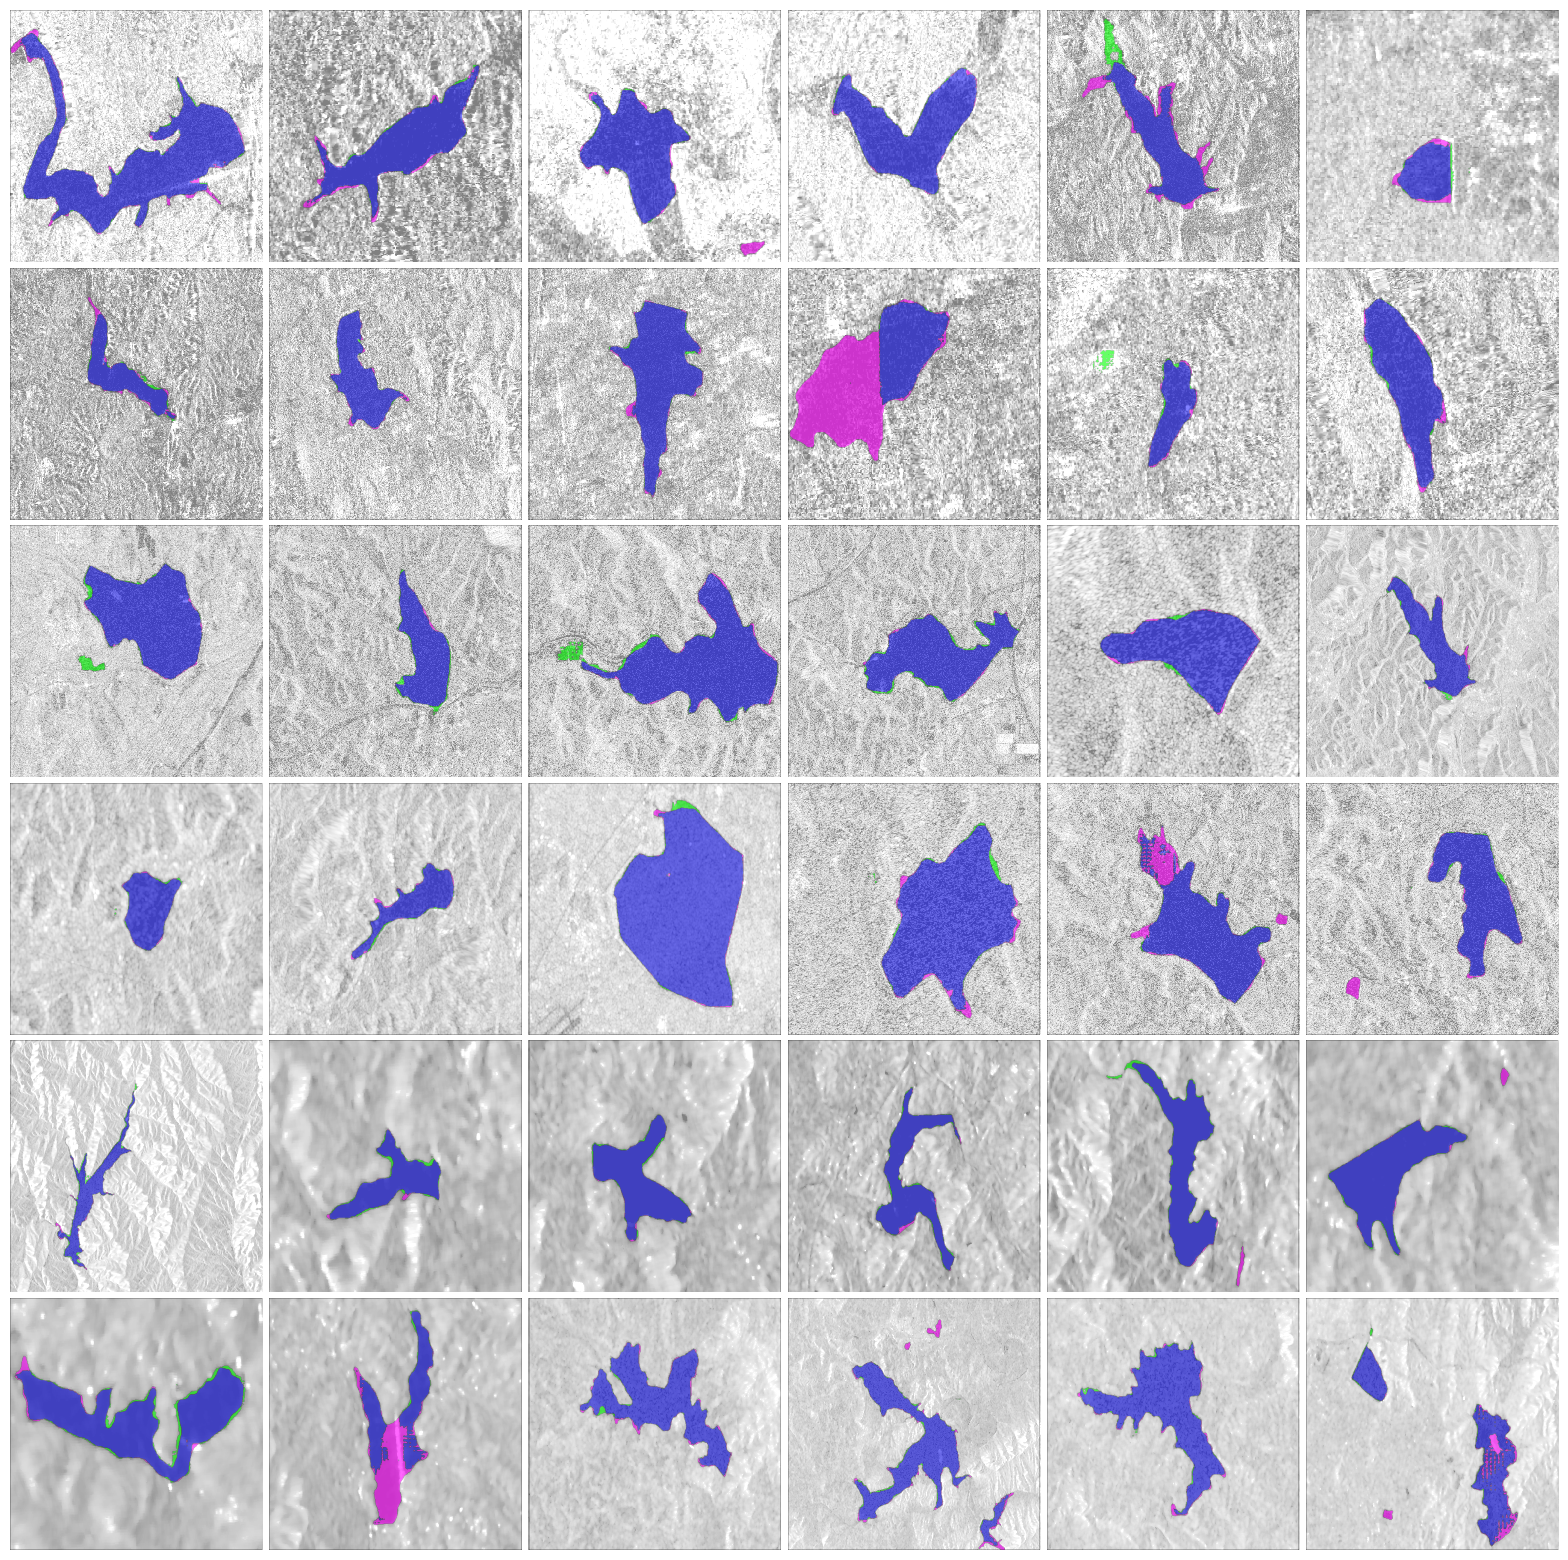

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.color import rgb2gray
from skimage.measure import find_contours

# images_tuned_list와 masks_binary_list가 각각 RGB 이미지와 바이너리 마스크 목록이라고 가정합니다.
# 경계 매개변수
border_color = 'black'
border_width = 0.35

# 36개 이미지에 대한 6x6 서브플롯 그리드를 만듭니다.
fig, axs = plt.subplots(6, 6, figsize=(20, 20))

# 쉬운 반복을 위해 서브플롯 그리드를 평평하게 만듭니다.
axs = axs.flatten()

# 표시할 36개의 이미지를 선택하세요
selected_indices = [0,1, 2, 3, 4, 5, 6, 7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
# 선택된 인덱스를 반복합니다
for i, index in enumerate(selected_indices):
    # 인덱스가 데이터 범위 내에 있는지 확인하세요
    if index < len(images_tuned_list):
        # RGB 이미지 표시
        gray_image = rgb2gray(images_tuned_list[index])

        axs[i].imshow(gray_image, cmap='gray', interpolation='none', alpha=0.5)  # Adjust alpha value as needed

        # 분할 결과에 대한 알파 채널이 있는 마스크 생성
        ground_truth_mask = (ground_truth_test_masks[index])
        mask = (masks_tuned_list[index])

        # 진정한 양성 반응을 위해 알파 채널이 있는 파란색 마스크를 만듭니다.
        true_positive_mask = (mask == 1) & (ground_truth_mask == 1)
        blue_mask = np.stack([np.zeros_like(true_positive_mask), np.zeros_like(true_positive_mask), true_positive_mask], axis=-1)
        blue_mask_rgba = np.concatenate([blue_mask, true_positive_mask[:, :, None].astype(float)], axis=-1)
        axs[i].imshow(blue_mask_rgba, alpha=0.50)

        # 거짓 경보에 대한 알파 채널이 있는 노란색 마스크 생성
        false_alarm_mask = (mask == 1) & (ground_truth_mask == 0)
        tight_green_mask = np.stack([np.zeros_like(false_alarm_mask), false_alarm_mask, np.zeros_like(false_alarm_mask)], axis=-1)
        tight_green_mask_rgba = np.concatenate([tight_green_mask, false_alarm_mask[:, :, None].astype(float)], axis=-1)
        axs[i].imshow(tight_green_mask_rgba, alpha=0.60)

        # 놓친 알람에 대한 알파 채널이 있는 빨간색 마스크 생성
        missed_alarm_mask = (mask == 0) & (ground_truth_mask == 1)
        magenta_mask = np.stack([missed_alarm_mask, np.zeros_like(missed_alarm_mask), missed_alarm_mask], axis=-1)
        magenta_mask_rgba = np.concatenate([magenta_mask, missed_alarm_mask[:, :, None].astype(float)], axis=-1)
        axs[i].imshow(magenta_mask_rgba, alpha=0.60)

        # 이미지 주위에 검은색 테두리를 추가합니다.
        rect = Rectangle((0, 0), gray_image.shape[1], gray_image.shape[0], linewidth=border_width, edgecolor=border_color, facecolor='none')
        axs[i].add_patch(rect)

        # 더 나은 시각화를 위해 축 레이블을 끄세요
        axs[i].axis('off')

# 서브플롯 레이블이 잘리지 않도록 레이아웃을 조정하세요
plt.subplots_adjust(wspace=0.02, hspace=0.02)
# 서브플롯 레이블이 잘리지 않도록 레이아웃을 조정하세요
# 600 DPI로 그림을 저장하세요
plt.subplots_adjust(wspace=0.02, hspace=0.02)

output_path = 'D:/DATA/SAM_Fine_Tune/Water-Bodies-Dataset/ViTSAML_AL2_Test36Images_300Epochs.png'
plt.savefig(output_path, dpi=600, bbox_inches='tight')
plt.show()

확인

In [23]:
import numpy as np

def binary_segmentation_metrics(predictions, targets):
    # 토치 텐서를 넘파이 배열로 변환
    predictions = predictions.squeeze()
    targets = targets
    # 예측을 이진 값(0 또는 1)으로 변환
    predictions_binary = (predictions > 0.5).astype(int)
    targets_binary = targets.astype(int)

    # True Positives (TP): 예측과 타겟이 모두 양성입니다.
    TP = np.sum((predictions_binary == 1) & (targets == 1))

    # 거짓 양성(FP): 예측은 양성이지만 대상은 음성입니다.
    FP = np.sum((predictions_binary == 1) & (targets == 0))

    # 거짓 부정(FN): 예측은 부정이지만 대상은 양성입니다.
    FN = np.sum((predictions_binary == 0) & (targets == 1))

    # True Negatives (TN): 예측과 타겟이 모두 음수입니다.
    TN = np.sum((predictions_binary == 0) & (targets == 0))

    eps = 1e-5
    accuracy = (TP + TN + eps) / (TP + FP + FN + TN + eps)
    precision = (TP + eps) / (TP + FP + eps)
    recall = (TP + eps) / (TP + FN + eps)
    f_score = 2 * (precision * recall) / (precision + recall)
    dice = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    iou = (TP + eps) / (TP + FP + FN + eps)

    total = TP + FP + FN + TN
    p_o = (TP + TN) / total
    p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
    kappa = (p_o - p_e) / (1 - p_e)

    return accuracy, precision, recall, f_score, iou, kappa, FP, FN, TP, TN, dice

def categorize_metric(metric_value, metric_name):
    if metric_name == 'IoU':
        if metric_value > 0.90:
            return "Excellent"
        elif 0.85 <= metric_value <= 0.90:
            return "Good"
        elif 0.75 <= metric_value < 0.85:
            return "Fair"
        elif 0.65 <= metric_value < 0.75:
            return "Poor"
        else:
            return "Unacceptable"
    elif metric_name == 'Precision':
        if metric_value > 0.95:
            return "Excellent"
        elif 0.85 <= metric_value <= 0.95:
            return "Good"
        elif 0.65 <= metric_value < 0.85:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'Kappa':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'F-Score':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    elif metric_name == 'Recall':
        if metric_value > 0.88:
            return "Excellent"
        elif 0.78 <= metric_value <= 0.88:
            return "Good"
        elif 0.68 <= metric_value < 0.78:
            return "Moderate"
        else:
            return "Fail"
    else:
        return "Unknown"

def calculate_metrics_for_images(predictions_list, targets_list):
    num_masks = len(predictions_list)

    all_metrics = []

    for i in range(num_masks):
        metrics = binary_segmentation_metrics(predictions_list[i], targets_list[i])

        metrics_dict = {
            'Accuracy': metrics[0],
            'Precision': metrics[1],
            'Recall': metrics[2],
            'F-Score': metrics[3],
            'IoU': metrics[4],
            'Kappa': metrics[5],
            'FP': metrics[6],
            'FN': metrics[7],
            'TP': metrics[8],
            'TN': metrics[9],
            'Dice': metrics[10],
        }

        categorized_metrics = {}
        for metric_name, value in metrics_dict.items():
            category = categorize_metric(value, metric_name)
            categorized_metrics[metric_name + '_Category'] = category

        all_metrics.append({**metrics_dict, **categorized_metrics})

    return all_metrics

# 사용 예

metrics_list = calculate_metrics_for_images(masks_tuned_list, ground_truth_test_masks)

# 각 카테고리에 대한 카운터 초기화
excellent_count_iou = 0
good_count_iou = 0
moderate_count_iou = 0
poor_count_iou = 0
fail_count_iou = 0

excellent_count_precision = 0
good_count_precision = 0
moderate_count_precision = 0
fail_count_precision = 0

excellent_count_kappa = 0
good_count_kappa = 0
moderate_count_kappa = 0
fail_count_kappa = 0

excellent_count_fscore = 0
good_count_fscore = 0
moderate_count_fscore = 0
fail_count_fscore = 0

excellent_count_recall = 0
good_count_recall = 0
moderate_count_recall = 0
fail_count_recall = 0

for i, metrics in enumerate(metrics_list):
    for metric_name, value in metrics.items():
          if metric_name.endswith('_Category'):
            category = value
            if metric_name.startswith('IoU'):
                if category == 'Excellent':
                    excellent_count_iou += 1
                elif category == 'Good':
                    good_count_iou += 1
                elif category == 'Fair':
                    moderate_count_iou += 1
                elif category == 'Poor':
                    poor_count_iou += 1
                elif category == 'Unacceptable':
                    fail_count_iou += 1
            elif metric_name.startswith('Precision'):
                if category == 'Excellent':
                    excellent_count_precision += 1
                elif category == 'Good':
                    good_count_precision += 1
                elif category == 'Moderate':
                    moderate_count_precision += 1
                elif category == 'Fail':
                    fail_count_precision += 1
            elif metric_name.startswith('Kappa'):
                if category == 'Excellent':
                    excellent_count_kappa += 1
                elif category == 'Good':
                    good_count_kappa += 1
                elif category == 'Moderate':
                    moderate_count_kappa += 1
                elif category == 'Fail':
                    fail_count_kappa += 1
            elif metric_name.startswith('F-Score'):
                if category == 'Excellent':
                    excellent_count_fscore += 1
                elif category == 'Good':
                    good_count_fscore += 1
                elif category == 'Moderate':
                    moderate_count_fscore += 1
                elif category == 'Fail':
                    fail_count_fscore += 1
            elif metric_name.startswith('Recall'):
                if category == 'Excellent':
                    excellent_count_recall += 1
                elif category == 'Good':
                    good_count_recall += 1
                elif category == 'Moderate':
                    moderate_count_recall += 1
                elif category == 'Fail':
                    fail_count_recall += 1

# 백분율을 계산하다
total_images = len(metrics_list)

excellent_percentage_iou = (excellent_count_iou / total_images) * 100
good_percentage_iou = (good_count_iou / total_images) * 100
moderate_percentage_iou = (moderate_count_iou / total_images) * 100
poor_percentage_iou = (poor_count_iou / total_images) * 100
fail_percentage_iou = (fail_count_iou / total_images) * 100

excellent_percentage_precision = (excellent_count_precision / total_images) * 100
good_percentage_precision = (good_count_precision / total_images) * 100
moderate_percentage_precision = (moderate_count_precision / total_images) * 100
fail_percentage_precision = (fail_count_precision / total_images) * 100

excellent_percentage_kappa = (excellent_count_kappa / total_images) * 100
good_percentage_kappa = (good_count_kappa / total_images) * 100
moderate_percentage_kappa = (moderate_count_kappa / total_images) * 100
fail_percentage_kappa = (fail_count_kappa / total_images) * 100

excellent_percentage_fscore = (excellent_count_fscore / total_images) * 100
good_percentage_fscore = (good_count_fscore / total_images) * 100
moderate_percentage_fscore = (moderate_count_fscore / total_images) * 100
fail_percentage_fscore = (fail_count_fscore / total_images) * 100

excellent_percentage_recall = (excellent_count_recall / total_images) * 100
good_percentage_recall = (good_count_recall / total_images) * 100
moderate_percentage_recall = (moderate_count_recall / total_images) * 100
fail_percentage_recall = (fail_count_recall / total_images) * 100

# 인쇄 횟수 및 백분율
print("Counts and Percentages of Images in Each Category for IoU:")
print(f"Excellent: {excellent_count_iou} ({excellent_percentage_iou}%)")
print(f"Good: {good_count_iou} ({good_percentage_iou}%)")
print(f"Moderate: {moderate_count_iou} ({moderate_percentage_iou}%)")
print(f"Poor: {poor_count_iou} ({poor_percentage_iou}%)")
print(f"Fail: {fail_count_iou} ({fail_percentage_iou}%)")
print()

print("Counts and Percentages of Images in Each Category for Precision:")
print(f"Excellent: {excellent_count_precision} ({excellent_percentage_precision}%)")
print(f"Good: {good_count_precision} ({good_percentage_precision}%)")
print(f"Moderate: {moderate_count_precision} ({moderate_percentage_precision}%)")
print(f"Fail: {fail_count_precision} ({fail_percentage_precision}%)")
print()

print("Counts and Percentages of Images in Each Category for Kappa:")
print(f"Excellent: {excellent_count_kappa} ({excellent_percentage_kappa}%)")
print(f"Good: {good_count_kappa} ({good_percentage_kappa}%)")
print(f"Moderate: {moderate_count_kappa} ({moderate_percentage_kappa}%)")
print(f"Fail: {fail_count_kappa} ({fail_percentage_kappa}%)")
print()

print("Counts and Percentages of Images in Each Category for F-Score:")
print(f"Excellent: {excellent_count_fscore} ({excellent_percentage_fscore}%)")
print(f"Good: {good_count_fscore} ({good_percentage_fscore}%)")
print(f"Moderate: {moderate_count_fscore} ({moderate_percentage_fscore}%)")
print(f"Fail: {fail_count_fscore} ({fail_percentage_fscore}%)")
print()

print("Counts and Percentages of Images in Each Category for Recall:")
print(f"Excellent: {excellent_count_recall} ({excellent_percentage_recall}%)")
print(f"Good: {good_count_recall} ({good_percentage_recall}%)")
print(f"Moderate: {moderate_count_recall} ({moderate_percentage_recall}%)")
print(f"Fail: {fail_count_recall} ({fail_percentage_recall}%)")
print()


Counts and Percentages of Images in Each Category for IoU:
Excellent: 26 (72.22222222222221%)
Good: 3 (8.333333333333332%)
Moderate: 5 (13.88888888888889%)
Poor: 0 (0.0%)
Fail: 2 (5.555555555555555%)

Counts and Percentages of Images in Each Category for Precision:
Excellent: 26 (72.22222222222221%)
Good: 10 (27.77777777777778%)
Moderate: 0 (0.0%)
Fail: 0 (0.0%)

Counts and Percentages of Images in Each Category for Kappa:
Excellent: 0 (0.0%)
Good: 0 (0.0%)
Moderate: 0 (0.0%)
Fail: 36 (100.0%)

Counts and Percentages of Images in Each Category for F-Score:
Excellent: 33 (91.66666666666666%)
Good: 1 (2.7777777777777777%)
Moderate: 1 (2.7777777777777777%)
Fail: 1 (2.7777777777777777%)

Counts and Percentages of Images in Each Category for Recall:
Excellent: 31 (86.11111111111111%)
Good: 3 (8.333333333333332%)
Moderate: 0 (0.0%)
Fail: 2 (5.555555555555555%)



C:\Users\user\AppData\Local\Temp\ipykernel_22044\3407063008.py:33: RuntimeWarning: overflow encountered in scalar multiply
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
C:\Users\user\AppData\Local\Temp\ipykernel_22044\3407063008.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
C:\Users\user\AppData\Local\Temp\ipykernel_22044\3407063008.py:34: RuntimeWarning: invalid value encountered in scalar divide
  kappa = (p_o - p_e) / (1 - p_e)
C:\Users\user\AppData\Local\Temp\ipykernel_22044\3407063008.py:33: RuntimeWarning: overflow encountered in scalar add
  p_e = ((TP + FP) * (TP + FN) + (FN + TN) * (FP + TN)) / (total ** 2)
